# Purpose Statement

This Notebook Introduces how to download our Benchmark datasets and a single benchmark method for post-processing an Deterministic forecast (MOS), it is based on the 2019 paper by Chapman et al. Please see their paper for an exploration of a few MOS systems, and other interesting methods for post-process bench marking. A brief description is also below:

Paper URL: [Chapman et al (2019)](https://agupubs.onlinelibrary.wiley.com/doi/full/10.1029/2019GL083662)

Three seperate lead times (in hours) are available for this tutorial data the options are: **F006_zarr, F048_zarr, and F168_zarr.** to be changed in the data ingest cell below. 

####  Model Output Statistics (EMOS)
----



## Import Necessary Packages:

In [529]:
import numpy as np
import pandas as pd
import glob
import os
import matplotlib.pyplot as plt
from datetime import datetime
from datetime import timedelta
import time
import xarray as xr
from netCDF4 import Dataset

import keras
from keras.layers import Input, Dense, merge, Embedding, Flatten, Concatenate,Conv2D,BatchNormalization,Dropout,MaxPooling2D
from keras.models import Model, Sequential
from keras.optimizers import Adam, SGD
import keras.backend as K
from keras.callbacks import EarlyStopping

from cartopy import config
import cartopy.crs as ccrs
import cartopy.feature as cf
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import palettable

import random 
random.seed(1) #for reproduceability. 
import matplotlib.ticker as mticker
from sklearn import datasets, linear_model, metrics 
# import utils

## Helpful Functions

In [524]:
def build_MOS_network_keras(compile=False, optimizer='sgd', lr=0.1):
    """Build (and maybe compile) EMOS network in keras.
    Args:
        compile: If true, compile model
        optimizer: String of keras optimizer
        lr: learning rate
    Returns:
        model: Keras model
    """
    vars_in = Input(shape=(1,))
    mean_out = Dense(1, activation='linear')(vars_in)
    model = Model(inputs=vars_in, outputs=mean_out)

    if compile:
        opt = keras.optimizers.__dict__[optimizer](lr=lr)
        model.compile(optimizer=opt, loss='mae')
    return model

def rmse(guess,truth):
    guess = np.squeeze(guess)
    truth = np.squeeze(truth)
    n = len(truth)
    rms=np.linalg.norm((guess) - (truth)) / np.sqrt(n)
    return rms


def bias(guess,truth):
    bb = np.mean(guess)-np.mean(truth)
    return bb

def corrss(guess,truth):
    bb = np.corrcoef(np.squeeze(guess),np.squeeze(truth))[0,1]
    return bb


def crmse(guess,truth):
    guess = np.squeeze(guess)
    truth = np.squeeze(truth)
    mg = np.mean(guess)
    mt = np.mean(truth)
    n = len(truth)
    bb=np.linalg.norm((guess-mg) - (truth-mt)) / np.sqrt(n)
    return bb

## Data Ingest

In [494]:
AllDatTOT = xr.open_zarr('/Users/will/Desktop/Haupt/Will/F006_zarr/')
AllDat = xr.open_zarr('/Users/will/Desktop/Haupt/Will/F006_zarr/')
AllDat
#Let's only look at February for this... comment this line to look at every month
AllDat = AllDat.sel(forecast_reference_time=AllDat.forecast_reference_time.dt.month.isin([2]))

### Split the data into appropriate testing and training chunks

Let's train on 2007-2014, validate on 2015, test on 2015 onwards

In [492]:
# ############ Train
Dat_Training = AllDat.loc[dict(forecast_reference_time=slice('2006-02-01T01:00:00', '2015-02-28T12:00:00'))]
# np_Training=Dat_Training.to_array().values
# ############ Test
Dat_Validate = AllDat.loc[dict(forecast_reference_time=slice('2016-02-01T01:00:00', '2016-02-28T12:00:00'))]
# np_Validate=Dat_Validate.to_array().values
# ############ Validate
Dat_Test= AllDat.loc[dict(forecast_reference_time=slice('2017-02-01T01:00:00', '2017-02-28T12:00:00'))]
# np_Test=Dat_Test.to_array().values

In [129]:
title_str = AllDat.forecast_reference_time.values[510]
str(title_str)[:19]

'2007-07-20T12:00:00'

## Lets Take a look at the IVT field with Cartopy

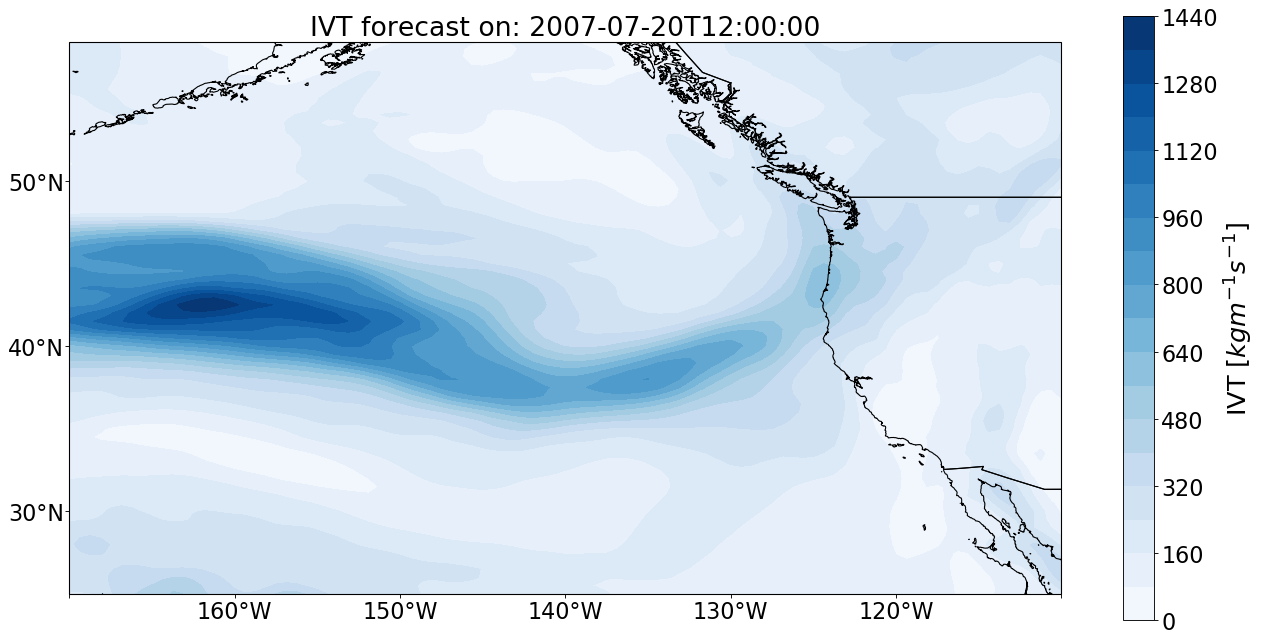

In [495]:
#set plotting variables
fornum = 510
lat = AllDat.lat.values
lon = AllDat.lon.values
IVT = AllDatTOT.IVT.values[fornum,:,:]
title_str = str(AllDatTOT.forecast_reference_time.values[fornum])[:19]
#

proj = ccrs.PlateCarree()
plt.figure(figsize=(20,20), dpi= 80, facecolor='w', edgecolor='k')
ax = plt.subplot(1, 1, 1,projection = proj)
proj = ccrs.PlateCarree()
ax.add_feature(cf.BORDERS)

ax.set_xticks(np.arange(-180,180,10), crs=proj)
ax.set_yticks(np.arange(20,80,10), crs=proj)
labels = [item.get_text() for item in ax.get_xticklabels()]
empty_string_labels = ['']*len(labels)
ax.set_xticklabels(empty_string_labels)

labels = [item.get_text() for item in ax.get_yticklabels()]
empty_string_labels = ['']*len(labels)
ax.set_yticklabels(empty_string_labels)

ax.add_feature(cf.NaturalEarthFeature(
               category='cultural',
               name='admin_1_states_provinces_lines',
               scale='10m',
               facecolor='none'))

ax.coastlines('10m')
ax.add_feature(cf.BORDERS)
ax.set_extent([-170, -110, 25, 55])

# print(scalesP)
plt.contourf(lon,lat,IVT,20,cmap='Blues')
bb = plt.colorbar(shrink=0.5)
bb.ax.tick_params(labelsize=20) 
bb.set_label('IVT [$kg m^{-1} s^{-1}$]',fontsize=23)

plt.title('IVT forecast on: ' + title_str, fontsize =24)

ax.tick_params(axis='both', which='major', labelsize=25)

gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=2, color='gray', alpha=0, linestyle='--')
gl.xlabels_top = False
gl.ylabels_left = True
gl.xlines = False
gl.ylabels_right=False
gl.xlocator = mticker.FixedLocator(np.arange(-180,180,10))
gl.ylocator = mticker.FixedLocator(np.arange(20,80,10))

gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlabel_style = {'size': 20, 'color': 'black'}
gl.ylabel_style = {'size': 20, 'color': 'black'}

## Correct a Local Forecast point: 

In [554]:
#Selecting a point in Northern California Near Bodega Bay
Loc_Training = Dat_Training.loc[dict(lat=slice(38, 38),lon=slice(-121.875,-121.875))]
# x = np.transpose(np.squeeze(Loc_Training.get(['IVT',"SLP","IWV","Z500","u500","v500","uIVT","vIVT"]).to_array().values))
x = np.transpose(np.squeeze(Loc_Training.get(['IVT']).to_array().values))
y = np.squeeze(Loc_Training.get(['IVTm']).to_array().values)

Loc_Validate = Dat_Validate.loc[dict(lat=slice(38, 38),lon=slice(-121.875,-121.875))]
# x_v = np.transpose(np.squeeze(Loc_Validate.get(['IVT',"SLP","IWV","Z500","u500","v500","uIVT","vIVT"]).to_array().values))
x_v = np.transpose(np.squeeze(Loc_Validate.get(['IVT']).to_array().values))
y_v = np.squeeze(Loc_Validate.get(['IVTm']).to_array().values)

Loc_Testing = Dat_Test.loc[dict(lat=slice(38, 38),lon=slice(-121.875,-121.875))]
# x_t = np.transpose(np.squeeze(Loc_Testing.get(['IVT',"SLP","IWV","Z500","u500","v500","uIVT","vIVT"]).to_array().values))
x_t = np.transpose(np.squeeze(Loc_Testing.get(['IVT']).to_array().values))
y_t = np.squeeze(Loc_Testing.get(['IVTm']).to_array().values)

In [555]:
mos_net=build_MOS_network_keras(compile=True, optimizer='adam', lr=0.001)
mos_net.summary()

Model: "model_96"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_112 (InputLayer)       (None, 1)                 0         
_________________________________________________________________
dense_131 (Dense)            (None, 1)                 2         
Total params: 2
Trainable params: 2
Non-trainable params: 0
_________________________________________________________________


## For a Local Point Build a MOS model from Keras Library

In [527]:
#FIT PARAMETERS
#batch number and number of epochs to train: 
bn =20
epcs = 400

#### KERAS CALLBACKS TO ADD to Training######
filp = '/where/your/best/model/is/saved'
svbst = keras.callbacks.callbacks.ModelCheckpoint(filp, monitor='val_loss', 
                                                  verbose=1, save_best_only=True, save_weights_only=False)
#add this to the callbacks in fit function to save the best model on your personal machine. 

earlystop = keras.callbacks.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=10, 
                                                    verbose=1, mode='auto', restore_best_weights=True) 
rdclr = keras.callbacks.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, verbose=1, 
                                                    mode='auto', min_delta=0.0001, cooldown=0, min_lr=0)

#### Fitting the Model ######
mos_net.fit(x,y,batch_size=bn,validation_data=[x_v,y_v],epochs=epcs ,callbacks=[earlystop,rdclr])

Train on 475 samples, validate on 55 samples
Epoch 1/400
475/475 [==============================] - 1s 3ms/step - loss: 226.7450 - val_loss: 190.2890
Epoch 2/400
475/475 [==============================] - 0s 72us/step - loss: 223.9151 - val_loss: 187.8694
Epoch 3/400
475/475 [==============================] - 0s 82us/step - loss: 221.0585 - val_loss: 185.4454
Epoch 4/400
475/475 [==============================] - 0s 78us/step - loss: 218.2040 - val_loss: 183.0300
Epoch 5/400
475/475 [==============================] - 0s 74us/step - loss: 215.3620 - val_loss: 180.6222
Epoch 6/400
475/475 [==============================] - 0s 81us/step - loss: 212.5425 - val_loss: 178.2097
Epoch 7/400
475/475 [==============================] - 0s 89us/step - loss: 209.7038 - val_loss: 175.8089
Epoch 8/400
475/475 [==============================] - 0s 79us/step - loss: 206.8712 - val_loss: 173.4090
Epoch 9/400
475/475 [==============================] - 0s 77us/step - loss: 204.0533 - val_loss: 170.9508
Ep

Epoch 78/400
475/475 [==============================] - 0s 85us/step - loss: 20.0242 - val_loss: 20.0668
Epoch 79/400
475/475 [==============================] - 0s 90us/step - loss: 19.1888 - val_loss: 19.7221
Epoch 80/400
475/475 [==============================] - 0s 79us/step - loss: 18.4945 - val_loss: 19.5339
Epoch 81/400
475/475 [==============================] - 0s 78us/step - loss: 17.9776 - val_loss: 19.3983
Epoch 82/400
475/475 [==============================] - 0s 73us/step - loss: 17.5471 - val_loss: 19.2850
Epoch 83/400
475/475 [==============================] - 0s 74us/step - loss: 17.2241 - val_loss: 19.1824
Epoch 84/400
475/475 [==============================] - 0s 92us/step - loss: 16.9652 - val_loss: 19.1105
Epoch 85/400
475/475 [==============================] - 0s 91us/step - loss: 16.7593 - val_loss: 19.0702
Epoch 86/400
475/475 [==============================] - 0s 81us/step - loss: 16.6341 - val_loss: 19.0461
Epoch 87/400
475/475 [==============================] -

In [553]:
#adding additional predictor variables did not help

if len(x_t.shape) == 1:
    print('MOS RMSE:',(rmse(pp,y_t)))
    print('GFS RMSE:',(rmse(x_t,y_t)))
    print('MOS RMSE:',(crmse(pp,y_t)))
    print('GFS RMSE:',(crmse(x_t,y_t)))
    print('MOS bias:',(bias(pp,y_t))) ### debiasing is where this has helped. 
    print('GFS bias:',(bias(x_t,y_t)))
    print('MOS corr:',(corrss(pp,y_t)))
    print('GFS corr:',(corrss(x_t,y_t)))
else:
    print('MOS RMSE:',(rmse(pp,y_t)))
    print('GFS RMSE:',(rmse(x_t[:,0],y_t)))
    print('MOS RMSE:',(crmse(pp,y_t)))
    print('GFS RMSE:',(crmse(x_t[:,0],y_t)))
    print('MOS bias:',(bias(pp,y_t))) ### debiasing is where this has helped. 
    print('GFS bias:',(bias(x_t[:,0],y_t)))
    print('MOS corr:',(corrss(pp,y_t)))
    print('GFS corr:',(corrss(x_t[:,0],y_t)))





MOS RMSE: 43.39063323937617
GFS RMSE: 41.9722786947361
MOS RMSE: 42.85194820766635
GFS RMSE: 40.67750962659357
MOS bias: 6.8159637
GFS bias: 10.34465
MOS corr: 0.9744208548695772
GFS corr: 0.9769908903747409


## Do the whole domain with MOS for FEB:

In [559]:
#batch number and number of epochs to train: 
bn =20
epcs = 100
#

MOS_Feb = np.zeros_like(np.squeeze(Dat_Test.get(['IVT']).to_array().values))
FOR_Feb = np.zeros_like(np.squeeze(Dat_Test.get(['IVT']).to_array().values))


earlystop = keras.callbacks.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=10, 
                                                    verbose=0, mode='auto', restore_best_weights=True) 
rdclr = keras.callbacks.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, verbose=0, 
                                                    mode='auto', min_delta=0.0001, cooldown=0, min_lr=0)

#this takes a very long time fitting a keras model, so we will just use a sklearn linear fit (but you could do it with either):
for ii,lla in enumerate(lat):
    print('doing lat:',lla)
    for jj,llo in enumerate(lon):
        #local Train/Validate/Test split:
        Loc_Training = Dat_Training.loc[dict(lat=slice(lla, lla),lon=slice(llo,llo))]
#         x = np.transpose(np.squeeze(Loc_Training.get(['IVT',"SLP","IWV","Z500","u500","v500","uIVT","vIVT"]).to_array().values))
        x = np.transpose(np.squeeze(Loc_Training.get(['IVT']).to_array().values))
        y = np.squeeze(Loc_Training.get(['IVTm']).to_array().values)

        Loc_Validate = Dat_Validate.loc[dict(lat=slice(lla, lla),lon=slice(llo,llo))]
#         x_v = np.transpose(np.squeeze(Loc_Validate.get(['IVT',"SLP","IWV","Z500","u500","v500","uIVT","vIVT"]).to_array().values))
        x_v = np.transpose(np.squeeze(Loc_Validate.get(['IVT']).to_array().values))
        y_v = np.squeeze(Loc_Validate.get(['IVTm']).to_array().values)

        Loc_Testing = Dat_Test.loc[dict(lat=slice(lla, lla),lon=slice(llo,llo))]
#         x_t = np.transpose(np.squeeze(Loc_Testing.get(['IVT',"SLP","IWV","Z500","u500","v500","uIVT","vIVT"]).to_array().values))
        x_t = np.transpose(np.squeeze(Loc_Testing.get(['IVT']).to_array().values))
        y_t = np.squeeze(Loc_Testing.get(['IVTm']).to_array().values)
        
        #define & fit new model (IF USING KERAS) uncomment following lines:
        ######
#         mos_net=build_MOS_network_keras(compile=True, optimizer='adam', lr=0.001)
#         mos_net.fit(x,y,batch_size=bn,validation_data=[x_v,y_v],epochs=epcs ,callbacks=[earlystop,rdclr],verbose=0)
#         pp = mos_net.predict(x_t)
        #######
        
        #regulare linear regression fit (can be multivariate)
        reg = linear_model.LinearRegression() 
        
        if len(x_t.shape) == 1:
            reg.fit(x.reshape(-1,1),y.reshape(-1,1))
            pp = reg.predict(x_t.reshape(-1,1))
            FOR_Feb[:,ii,jj] = np.squeeze(x_t)
        else:
            reg.fit(x,y)
            pp = reg.predict(x_t)
            FOR_Feb[:,ii,jj] = np.squeeze(x_t[:,0])
        #make point prediction:

        MOS_Feb[:,ii,jj] = np.squeeze(pp)        

doing lat: 10.0
doing lat: 10.5
doing lat: 11.0
doing lat: 11.5
doing lat: 12.0
doing lat: 12.5
doing lat: 13.0
doing lat: 13.5
doing lat: 14.0
doing lat: 14.5
doing lat: 15.0
doing lat: 15.5
doing lat: 16.0
doing lat: 16.5
doing lat: 17.0
doing lat: 17.5
doing lat: 18.0
doing lat: 18.5
doing lat: 19.0
doing lat: 19.5
doing lat: 20.0
doing lat: 20.5
doing lat: 21.0
doing lat: 21.5
doing lat: 22.0
doing lat: 22.5
doing lat: 23.0
doing lat: 23.5
doing lat: 24.0
doing lat: 24.5
doing lat: 25.0
doing lat: 25.5
doing lat: 26.0
doing lat: 26.5
doing lat: 27.0
doing lat: 27.5
doing lat: 28.0
doing lat: 28.5
doing lat: 29.0
doing lat: 29.5
doing lat: 30.0
doing lat: 30.5
doing lat: 31.0
doing lat: 31.5
doing lat: 32.0
doing lat: 32.5
doing lat: 33.0
doing lat: 33.5
doing lat: 34.0
doing lat: 34.5
doing lat: 35.0
doing lat: 35.5
doing lat: 36.0
doing lat: 36.5
doing lat: 37.0
doing lat: 37.5
doing lat: 38.0
doing lat: 38.5
doing lat: 39.0
doing lat: 39.5
doing lat: 40.0
doing lat: 40.5
doing la

In [558]:
MOS_Feb

(55, 101, 113)

In [500]:

#get just that month:
